In [1]:
!unzip /content/dataset_ts.zip -d /content/data

Archive:  /content/dataset_ts.zip
   creating: /content/data/test/
   creating: /content/data/test/features/
  inflating: /content/data/test/features/0000.npy  
  inflating: /content/data/test/features/0001.npy  
  inflating: /content/data/test/features/0002.npy  
  inflating: /content/data/test/features/0003.npy  
  inflating: /content/data/test/features/0004.npy  
  inflating: /content/data/test/features/0005.npy  
  inflating: /content/data/test/features/0006.npy  
  inflating: /content/data/test/features/0007.npy  
  inflating: /content/data/test/features/0008.npy  
  inflating: /content/data/test/features/0009.npy  
  inflating: /content/data/test/features/0010.npy  
  inflating: /content/data/test/features/0011.npy  
  inflating: /content/data/test/features/0012.npy  
  inflating: /content/data/test/features/0013.npy  
  inflating: /content/data/test/features/0014.npy  
  inflating: /content/data/test/features/0015.npy  
  inflating: /content/data/test/features/0016.npy  
  infla

## Conv2dGRU

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ------------------- Dataset -------------------
class FolderTimeSeriesDataset(Dataset):
    """
    PyTorch Dataset load từng file .npy từ folder:
    dataset_ts/train/val/test
        features/0000.npy
        target/0000.npy
    """
    def __init__(self, root_dir, time_in=30, time_out=1):
        self.feature_dir = os.path.join(root_dir, "features")
        self.target_dir  = self.feature_dir

        self.feature_files = sorted(os.listdir(self.feature_dir))
        self.target_files  = sorted(os.listdir(self.target_dir))
        assert len(self.feature_files) == len(self.target_files), "features != target"

        self.time_in = time_in
        self.time_out = time_out

        # Tạo danh sách index cho sliding window
        self.sample_indices = []
        total_timesteps = len(self.feature_files)
        for i in range(total_timesteps - time_in - time_out + 1):
            self.sample_indices.append(i)

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        start_idx = self.sample_indices[idx]

        # Load input sequence
        X_list = []
        for i in range(start_idx, start_idx + self.time_in):
            feat = np.load(os.path.join(self.feature_dir, self.feature_files[i]))  # [H,W,C]
            feat = np.transpose(feat, (2,0,1))  # [C,H,W]
            X_list.append(feat)
        X = np.stack(X_list, axis=0)  # [time_in, C, H, W]

        # Load output sequence
        Y_list = []
        for i in range(start_idx + self.time_in, start_idx + self.time_in + self.time_out):
            targ = np.load(os.path.join(self.target_dir, self.target_files[i]))  # [H,W,C] (C=1)
            targ = np.transpose(targ, (2,0,1))  # [C,H,W]
            Y_list.append(targ)
        Y = np.stack(Y_list, axis=0)  # [time_out, C, H, W]

        return torch.FloatTensor(X), torch.FloatTensor(Y)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.bias = bias

        # Gộp x_t và h_{t-1} rồi conv ra 2 * hidden_dim (z, r)
        self.conv_gates = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=2 * hidden_dim,
            kernel_size=kernel_size,
            padding=self.padding,
            bias=bias
        )

        # Conv cho candidate hidden state \tilde{h}_t
        self.conv_can = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            padding=self.padding,
            bias=bias
        )

    def forward(self, x, h_cur):
        """
        x: [B, C_in, H, W]
        h_cur: [B, hidden_dim, H, W]
        """
        # Tính z_t, r_t
        combined = torch.cat([x, h_cur], dim=1)  # [B, C_in + hidden_dim, H, W]
        gates = self.conv_gates(combined)        # [B, 2*hidden_dim, H, W]
        z_gate, r_gate = torch.split(gates, self.hidden_dim, dim=1)

        z = torch.sigmoid(z_gate)
        r = torch.sigmoid(r_gate)

        # Candidate hidden state
        combined_reset = torch.cat([x, r * h_cur], dim=1)
        h_tilde = torch.tanh(self.conv_can(combined_reset))

        # Cập nhật hidden
        h_next = (1 - z) * h_cur + z * h_tilde
        return h_next

    def init_hidden(self, batch_size, image_size, device):
        H, W = image_size
        return torch.zeros(batch_size, self.hidden_dim, H, W, device=device)

class ConvGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim if isinstance(hidden_dim, list) else [hidden_dim] * num_layers
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.return_all_layers = return_all_layers

        self.cell_list = nn.ModuleList()
        for i in range(num_layers):
            cur_in = input_dim if i == 0 else self.hidden_dim[i-1]
            self.cell_list.append(
                ConvGRUCell(cur_in, self.hidden_dim[i], kernel_size, bias=bias)
            )

    def forward(self, x, hidden_state=None):
        """
        x: [B, T, C, H, W] nếu batch_first=True
        hidden_state: list length = num_layers, mỗi phần tử là h_0 shape [B, hidden_dim, H, W]
        """
        if not self.batch_first:
            x = x.permute(1, 0, 2, 3, 4)  # [T,B,C,H,W] -> [B,T,C,H,W]

        B, T, C, H, W = x.size()
        device = x.device

        # Khởi tạo hidden nếu chưa có
        if hidden_state is None:
            hidden_state = [cell.init_hidden(B, (H, W), device) for cell in self.cell_list]

        layer_output_list = []
        last_state_list = []

        cur_input = x
        for layer_idx in range(self.num_layers):
            h = hidden_state[layer_idx]
            output_inner = []

            for t in range(T):
                h = self.cell_list[layer_idx](cur_input[:, t], h)  # [B, hidden_dim, H, W]
                output_inner.append(h)

            layer_out = torch.stack(output_inner, dim=1)  # [B, T, hidden_dim, H, W]
            cur_input = layer_out

            layer_output_list.append(layer_out)
            last_state_list.append(h)  # chỉ có h, không có c

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]   # list 1 phần tử
            last_state_list = last_state_list[-1:]       # list 1 phần tử

        return layer_output_list, last_state_list


class ConvGRUForecaster(nn.Module):
    def __init__(self, input_channels, hidden_dims=[64, 32, 16],
                 kernel_size=3, dropout_rate=0.2):
        super().__init__()
        self.convgru = ConvGRU(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=len(hidden_dims),
            batch_first=True
        )
        self.batch_norm = nn.BatchNorm2d(hidden_dims[-1])
        self.dropout = nn.Dropout2d(dropout_rate)
        self.output_conv = nn.Conv2d(
            in_channels=hidden_dims[-1],
            out_channels=input_channels,
            kernel_size=3,
            padding=1
        )

    def forward(self, x):
        """
        x: [B, T_in, C, H, W]
        return: [B, 1, C, H, W]
        """
        layer_out, last_state = self.convgru(x)
        # last_state là list (1 phần tử nếu return_all_layers=False)
        # mỗi phần tử là tensor [B, hidden_dim_last, H, W]
        h_last = last_state[0]  # [B, hidden_dims[-1], H, W]

        h_last = self.batch_norm(h_last)
        h_last = self.dropout(h_last)
        out = self.output_conv(h_last)    # [B, C_in, H, W]
        out = torch.sigmoid(out)
        out = out.unsqueeze(1)            # [B, 1, C_in, H, W]
        return out


# ------------------- Training -------------------
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001,
                device='cuda', checkpoint_path='best_model.pth'):
    """
    Huấn luyện mô hình PyTorch với tqdm progress bars
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6
    )

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    history = {'train_loss': [], 'train_mae': [], 'val_loss': [], 'val_mae': []}

    print(f"\n{'='*60}")
    print(f"🚀 Training ConvLSTM Model on {device}")
    print(f"{'='*60}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Max epochs: {epochs}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        # Progress bar cho training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]',
                         leave=False, ncols=100)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - targets)).item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.6f}',
                'mae': f'{torch.mean(torch.abs(outputs - targets)).item():.6f}'
            })

        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        # Progress bar cho validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]',
                       leave=False, ncols=100)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                batch_loss = criterion(outputs, targets).item()
                batch_mae = torch.mean(torch.abs(outputs - targets)).item()

                val_loss += batch_loss
                val_mae += batch_mae

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.6f}',
                    'mae': f'{batch_mae:.6f}'
                })

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f}, "
              f"Val Loss: {val_loss:.6f}, Val MAE: {val_mae:.6f}")

        # Early stopping and checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"  ✓ Model saved (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs")
                break

    print(f"\n{'='*60}")
    print(f"✅ Training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"{'='*60}\n")

    return history

# ------------------- Autoregressive Forecast -------------------
def autoregressive_forecast(model, initial_seq, n_days=7, device='cuda'):
    """
    initial_seq: [1,time_in,C,H,W]
    """
    model.eval()
    current_seq = initial_seq.to(device)
    preds = []

    with torch.no_grad():
        for _ in range(n_days):
            out = model(current_seq)  # [1,1,C,H,W]
            preds.append(out[0,0].cpu().numpy())
            current_seq = torch.cat([current_seq[:,1:], out], dim=1)
    return np.array(preds)  # [n_days,C,H,W]

# ------------------- Visualization -------------------
def visualize_training(history):
    plt.figure(figsize=(10,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_results(history, true_data, predictions, feature_names=None, save_path=None):
    """
    Visualize training results và predictions
    true_data, predictions: (n_days, C, H, W) format
    """
    n_days, C, H, W = predictions.shape

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(C)]

    # 1. Training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Training & Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_training.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. Spatial predictions
    n_features_show = min(3, C)
    n_days_show = min(3, n_days)

    fig, axes = plt.subplots(n_days_show, n_features_show * 2,
                            figsize=(4*n_features_show*2, 4*n_days_show))

    if n_days_show == 1:
        axes = axes.reshape(1, -1)

    for day_idx in range(n_days_show):
        for feat_idx in range(n_features_show):
            # True
            ax_true = axes[day_idx, feat_idx*2]
            im1 = ax_true.imshow(true_data[day_idx, feat_idx, :, :],
                                cmap='viridis', vmin=0, vmax=1)
            ax_true.set_title(f'Day {day_idx+1} - {feature_names[feat_idx]} (True)',
                            fontweight='bold')
            ax_true.axis('off')
            plt.colorbar(im1, ax=ax_true, fraction=0.046)

            # Predicted
            ax_pred = axes[day_idx, feat_idx*2 + 1]
            im2 = ax_pred.imshow(predictions[day_idx, feat_idx, :, :],
                                cmap='viridis', vmin=0, vmax=1)
            ax_pred.set_title(f'Day {day_idx+1} - {feature_names[feat_idx]} (Pred)',
                            fontweight='bold')
            ax_pred.axis('off')
            plt.colorbar(im2, ax=ax_pred, fraction=0.046)

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [4]:
import torch
from torch.utils.data import DataLoader
import os

time_in = 30   # số ngày input
time_out = 1   # số ngày output

train_dataset = FolderTimeSeriesDataset("data/train", time_in=time_in, time_out=time_out)
val_dataset   = FolderTimeSeriesDataset("data/val", time_in=time_in, time_out=time_out)
test_dataset  = FolderTimeSeriesDataset("data/test", time_in=time_in, time_out=time_out)

# Tạo DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")




input_channels = train_dataset[0][0].shape[1]  # số channel của features
hidden_dims = [64, 32, 16]                     # cấu hình hidden dims
kernel_size = 3
dropout_rate = 0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ConvGRUForecaster(
    input_channels=input_channels,
    hidden_dims=[64, 32, 16],
    kernel_size=3,
    dropout_rate=0.2
).to(device)

print(f"Model initialized on {device}")


# ----------------------------------------
# 3. Huấn luyện mô hình
# ----------------------------------------


epochs = 10
learning_rate = 0.001
checkpoint_path = "conv_gru_best.pth"

history = train_model(model, train_loader, val_loader, epochs=epochs, lr=learning_rate, device=device, checkpoint_path=checkpoint_path)


Train batches: 113, Val batches: 10, Test batches: 10
Model initialized on cuda

🚀 Training ConvLSTM Model on cuda
Training batches: 113
Validation batches: 10
Max epochs: 10



Epoch 1/10 - Train Loss: 0.028793, Train MAE: 0.125293, Val Loss: 0.018421, Val MAE: 0.095712
  ✓ Model saved (val_loss: 0.018421)


Epoch 2/10 - Train Loss: 0.015315, Train MAE: 0.086368, Val Loss: 0.027385, Val MAE: 0.124447


Epoch 3/10 - Train Loss: 0.014080, Train MAE: 0.081647, Val Loss: 0.022086, Val MAE: 0.110217


Epoch 4/10 - Train Loss: 0.012526, Train MAE: 0.077852, Val Loss: 0.013004, Val MAE: 0.083635
  ✓ Model saved (val_loss: 0.013004)


Epoch 5/10 - Train Loss: 0.012006, Train MAE: 0.076060, Val Loss: 0.014506, Val MAE: 0.080480


Epoch 6/10 - Train Loss: 0.011802, Train MAE: 0.075273, Val Loss: 0.010027, Val MAE: 0.069274
  ✓ Model saved (val_loss: 0.010027)


Epoch 7/10 - Train Loss: 0.011390, Train MAE: 0.073793, Val Loss: 0.011678, Val MAE: 0.074667


Epoch 8/10 - Train Loss: 0.011269, Train MAE: 0.073480, Val Loss: 0.013124, Val MAE: 0.081562


Epoch 9/10 - Train Loss: 0.011043, Train MAE: 0.072394, Val Loss: 0.009830, Val MAE: 0.067600
  ✓ Model saved (val_loss: 0.009830)


Epoch 10/10 - Train Loss: 0.010680, Train MAE: 0.071307, Val Loss: 0.012166, Val MAE: 0.080432

✅ Training completed!
Best validation loss: 0.009830



Predictions shape: (7, 24, 35, 35)


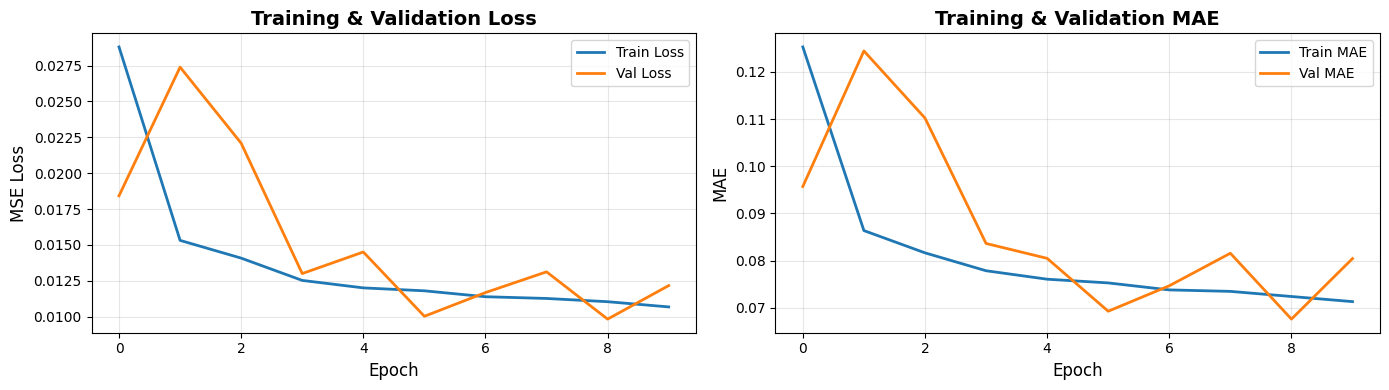

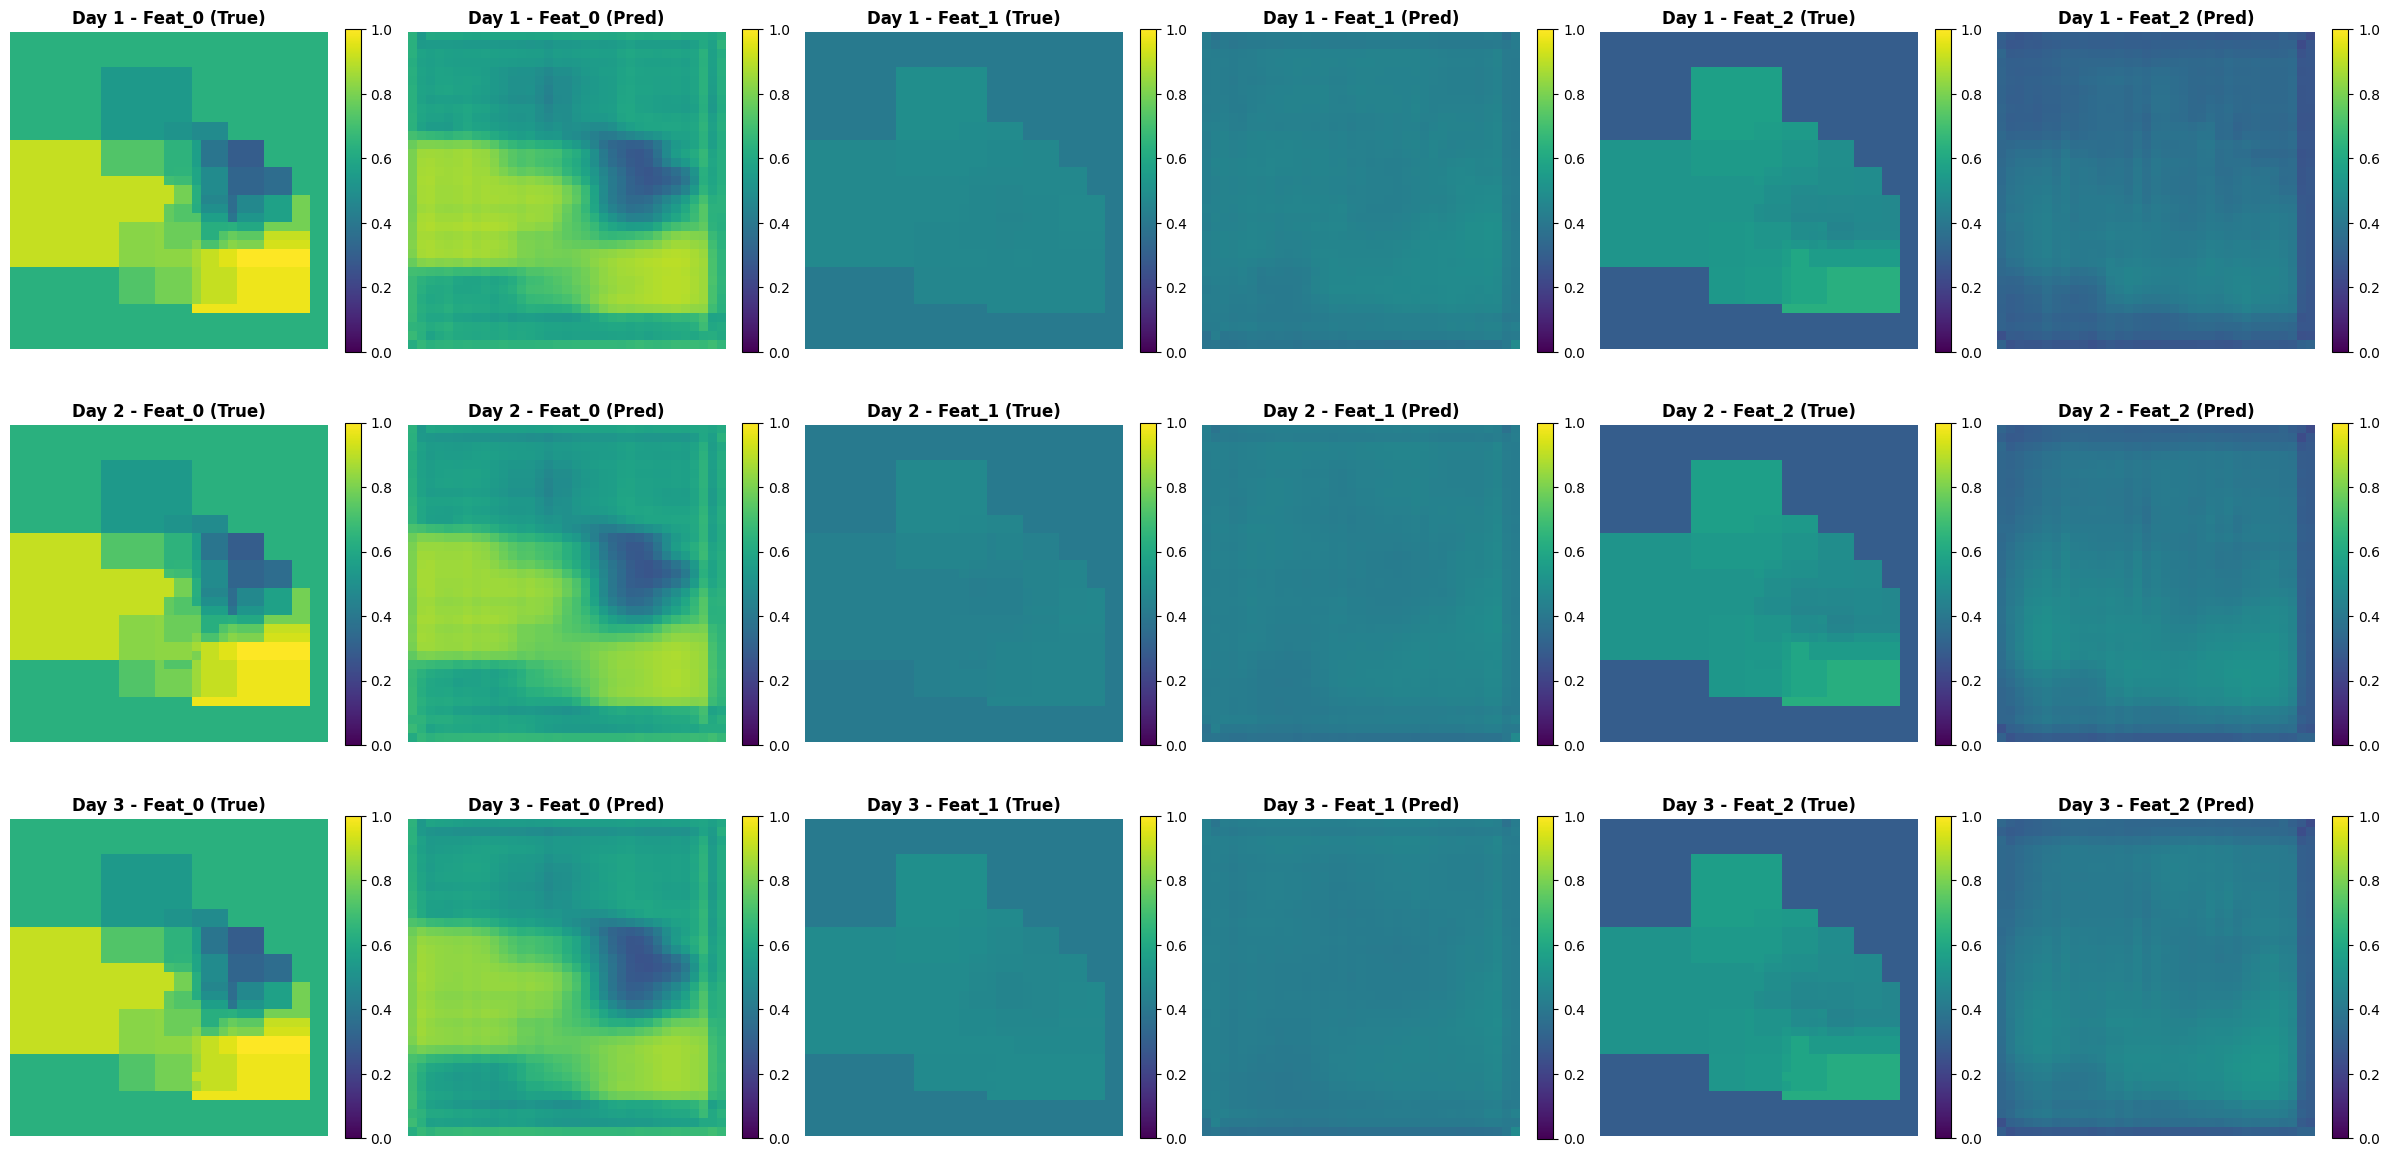

test MSE: 0.011006955523043871
test MAE: 0.0775947891175747


In [5]:
# Lấy 1 sequence đầu tiên trong test dataset
initial_seq, _ = test_dataset[0]  # initial_seq shape: (time_in, C, H, W)

# Thêm batch dimension: (1, time_in, C, H, W)
initial_seq = initial_seq.unsqueeze(0)

n_days_predict = 7

predictions = autoregressive_forecast(
    model=model,
    initial_seq=initial_seq,
    n_days=n_days_predict,
    device=device
)

print(f"Predictions shape: {predictions.shape}")  # (n_days, C, H, W)


# ----------------------------------------
# 5. Visualize kết quả
# ----------------------------------------


# Lấy ground truth 7 ngày tương ứng (chú ý test dataset đã sliding window)
true_data = torch.stack([test_dataset[i][1][0] for i in range(n_days_predict)]).numpy()  # (n_days, C, H, W)

visualize_results(
    history=history,
    true_data=true_data,
    predictions=predictions,
    feature_names=[f"Feat_{i}" for i in range(input_channels)],
    save_path=None
)
criterion = nn.MSELoss()

test_loss = 0.0
test_mae = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        batch_loss = criterion(outputs, targets).item()
        batch_mae = torch.mean(torch.abs(outputs - targets)).item()

        test_loss += batch_loss
        test_mae += batch_mae

test_loss /= len(val_loader)
test_mae /= len(val_loader)

print("test MSE:", test_loss)
print("test MAE:", test_mae)

## FPN

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
from tqdm import tqdm
import warnings
import torch.nn.functional as F
warnings.filterwarnings('ignore')


class TensorTimeSeriesDataset(Dataset):
    """
    Dataset PyTorch cho tensor 3D time-series lưu trên disk
    """
    def __init__(self, root_dir):
        """
        root_dir: đường dẫn tới folder 'train', 'val' hoặc 'test'
        """
        self.feature_dir = os.path.join(root_dir, "features")
        self.target_dir  = os.path.join(root_dir, "target")

        self.feature_files = sorted(os.listdir(self.feature_dir))
        self.target_files  = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        # Load feature và target
        feat_path = os.path.join(self.feature_dir, self.feature_files[idx])
        targ_path = os.path.join(self.target_dir, self.target_files[idx])

        feature = np.load(feat_path)  # [H, W, C]
        target  = np.load(targ_path)  # [H, W, 1]

        # Chuyển sang tensor và permute để Conv2D input: [C, H, W]
        feature = torch.from_numpy(feature).float().permute(2, 0, 1)  # [C,H,W]
        target  = torch.from_numpy(target).float().permute(2, 0, 1)   # [1,H,W]

        return feature, target


# ---------- Simple CNN backbone: trả ra 3 scale ----------
class SimpleBackbone(nn.Module):
    """
    Nhận 1 frame [B,C,H,W] -> trả [C2,C3,C4] với downsample 2,4,8 lần.
    """
    def __init__(self, in_channels=1, base_channels=32):
        super().__init__()
        # Stage 1: H,W
        self.conv1 = self._conv_block(in_channels, base_channels)
        # Stage 2: H/2,W/2
        self.conv2 = self._conv_block(base_channels, base_channels*2)
        # Stage 3: H/4,W/4
        self.conv3 = self._conv_block(base_channels*2, base_channels*4)

        self.pool = nn.MaxPool2d(2,2)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # x: [B,C,H,W]
        c1 = self.conv1(x)         # [B, F,   H,   W]
        p1 = self.pool(c1)         # [B, F,   H/2, W/2]
        c2 = self.conv2(p1)        # [B, 2F,  H/2, W/2]
        p2 = self.pool(c2)         # [B, 2F,  H/4, W/4]
        c3 = self.conv3(p2)        # [B, 4F,  H/4, W/4]
        return c1, c2, c3          # 3 scale

# ---------- FPN ----------
class FPN(nn.Module):
    """
    Nhận [C1 (H,W), C2 (H/2,W/2), C3 (H/4,W/4)]
    -> trả feature cuối ở full resolution H,W
    """
    def __init__(self, c1_channels, c2_channels, c3_channels, fpn_channels=64):
        super().__init__()
        # lateral convs
        self.lat_c1 = nn.Conv2d(c1_channels, fpn_channels, kernel_size=1)
        self.lat_c2 = nn.Conv2d(c2_channels, fpn_channels, kernel_size=1)
        self.lat_c3 = nn.Conv2d(c3_channels, fpn_channels, kernel_size=1)

        # smooth convs
        self.smooth1 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth2 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)

    def forward(self, c1, c2, c3):
        # Top-down pathway
        p3 = self.lat_c3(c3)                     # [B,F,H/4,W/4]
        p2 = self._upsample_add(p3, self.lat_c2(c2))  # [B,F,H/2,W/2]
        p1 = self._upsample_add(p2, self.lat_c1(c1))  # [B,F,H,W]

        # Smooth
        p2 = self.smooth2(p2)
        p1 = self.smooth1(p1)

        return p1  # feature ở full resolution

    def _upsample_add(self, x, y):
        # upsample x lên size của y rồi cộng
        _, _, H, W = y.shape
        return F.interpolate(x, size=(H, W), mode="bilinear", align_corners=False) + y

class RainfallFPN(nn.Module):
    """
    Stage 2: dự đoán rainfall từ feature của 1 ngày (C,H,W)
    Input : [B,C,H,W]   (feature 1 ngày, đã scale)
    Output: [B,1,H,W]   (rainfall scaled)
    """
    def __init__(self, in_channels, base_channels=32, fpn_channels=64, dropout_rate=0.1):
        super().__init__()
        self.backbone = SimpleBackbone(in_channels=in_channels,
                                       base_channels=base_channels)

        self.fpn = FPN(
            c1_channels=base_channels,
            c2_channels=base_channels*2,
            c3_channels=base_channels*4,
            fpn_channels=fpn_channels
        )

        self.dropout = nn.Dropout2d(dropout_rate)
        self.head = nn.Conv2d(fpn_channels, 1, kernel_size=3, padding=1)

    def forward(self, x):
        """
        x: [B,C,H,W]  (1 ngày feature)
        """
        c1, c2, c3 = self.backbone(x)   # 3 scale
        fpn_feat = self.fpn(c1, c2, c3) # [B,fpn_channels,H,W]
        fpn_feat = self.dropout(fpn_feat)
        out = self.head(fpn_feat)       # [B,1,H,W] rainfall (scaled)
        out = torch.sigmoid(out)
        return out



# ==================== TRAINING FUNCTION ====================
def train_model_unet(model, train_loader, val_loader, epochs, lr, device, checkpoint_path):
    """
    Huấn luyện mô hình U-Net với tqdm progress bars
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6
    )

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    history = {'train_loss': [], 'train_mae': [], 'val_loss': [], 'val_mae': []}

    print(f"\n{'='*60}")
    print(f"🚀 Training U-Net Model on {device}")
    print(f"{'='*60}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Max epochs: {epochs}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]',
                         leave=False, ncols=100)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - targets)).item()

            train_pbar.set_postfix({
                'loss': f'{loss.item():.6f}',
                'mae': f'{torch.mean(torch.abs(outputs - targets)).item():.6f}'
            })

        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]',
                       leave=False, ncols=100)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                batch_loss = criterion(outputs, targets).item()
                batch_mae = torch.mean(torch.abs(outputs - targets)).item()

                val_loss += batch_loss
                val_mae += batch_mae

                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.6f}',
                    'mae': f'{batch_mae:.6f}'
                })

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f}, "
              f"Val Loss: {val_loss:.6f}, Val MAE: {val_mae:.6f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, checkpoint_path)
            print(f"  ✓ Model saved (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs")
                break

    print(f"\n{'='*60}")
    print(f"✅ Training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"{'='*60}\n")

    return history



# ==================== VISUALIZATION ====================
def plot_training_history(history, save_path='training_history.png'):
    """
    Vẽ biểu đồ quá trình training
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history['train_mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📈 Training history saved to {save_path}")
    plt.show()

def evaluate_model(model, test_loader, device, minmax=None, robust=None):
    """
    Đánh giá mô hình trên tập test.
    Nếu có scaler_target thì tự động inverse_transform để so sánh trên giá trị thật (mm/ngày).
    """
    model.eval()
    criterion = nn.MSELoss()

    total_loss = 0.0
    total_mae = 0.0
    all_predictions = []
    all_targets = []

    print("\n🔍 Evaluating model on test set...")

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing', ncols=100):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            mae = torch.mean(torch.abs(outputs - targets))

            total_loss += loss.item()
            total_mae += mae.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_mae = total_mae / len(test_loader)

    preds = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    print(f"\n📊 Test Results (scaled):")
    print(f"  MSE Loss: {avg_loss:.6f}")
    print(f"  MAE: {avg_mae:.6f}")

    # ==============================
    # 🔁 Inverse transform (nếu có scaler)
    # ==============================
    if minmax is not None and robust is not None:
        # reshape về (N, H*W)
        N, C, H, W = preds.shape
        preds_2d = preds.reshape(-1, 1)
        targets_2d = targets.reshape(-1, 1)

        preds_inv = robust.inverse_transform(minmax.inverse_transform(preds_2d)).reshape(N, C, H, W)
        targets_inv = robust.inverse_transform(minmax.inverse_transform(targets_2d)).reshape(N, C, H, W)

        mse_real = np.mean((preds_inv - targets_inv) ** 2)
        mae_real = np.mean(np.abs(preds_inv - targets_inv))

        print(f"\n🌧️ Test Results (after inverse transform - mm/day):")
        print(f"  MSE: {mse_real:.6f}")
        print(f"  MAE: {mae_real:.6f}")

        return {
            'loss_scaled': avg_loss,
            'mae_scaled': avg_mae,
            'loss_real': mse_real,
            'mae_real': mae_real,
            'preds_scaled': preds,
            'targets_scaled': targets,
            'preds_real': preds_inv,
            'targets_real': targets_inv
        }

    return {
        'loss_scaled': avg_loss,
        'mae_scaled': avg_mae,
        'preds_scaled': preds,
        'targets_scaled': targets
    }

def visualize_predictions_last(predictions, targets, num_samples=3, channel=0, save_path='predictions.png'):
    """
    Hiển thị kết quả dự đoán
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        pred = predictions[i, channel]
        target = targets[i, channel]
        diff = np.abs(pred - target)

        # Target
        im1 = axes[i, 0].imshow(target, cmap='viridis')
        axes[i, 0].set_title(f'Sample {i+1}: Ground Truth', fontweight='bold')
        axes[i, 0].axis('off')
        plt.colorbar(im1, ax=axes[i, 0], fraction=0.046)

        # Prediction
        im2 = axes[i, 1].imshow(pred, cmap='viridis')
        axes[i, 1].set_title(f'Sample {i+1}: Prediction', fontweight='bold')
        axes[i, 1].axis('off')
        plt.colorbar(im2, ax=axes[i, 1], fraction=0.046)

        # Difference
        im3 = axes[i, 2].imshow(diff, cmap='Reds')
        axes[i, 2].set_title(f'Sample {i+1}: Absolute Error', fontweight='bold')
        axes[i, 2].axis('off')
        plt.colorbar(im3, ax=axes[i, 2], fraction=0.046)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"🖼️  Predictions saved to {save_path}")
    plt.show()

In [7]:
# ===== Stage 2: dataset dự đoán rainfall =====
rain_train_dataset = TensorTimeSeriesDataset("data/train")
rain_val_dataset   = TensorTimeSeriesDataset("data/val")
rain_test_dataset  = TensorTimeSeriesDataset("data/test")

rain_train_loader = DataLoader(rain_train_dataset, batch_size=8, shuffle=True)
rain_val_loader   = DataLoader(rain_val_dataset,   batch_size=8, shuffle=False)
rain_test_loader  = DataLoader(rain_test_dataset,  batch_size=8, shuffle=False)

# Lấy shape
X0, Y0 = rain_train_dataset[0]
in_channels = X0.shape[0]   # C
print("RainfallFPN in_channels:", in_channels)

out_channels = Y0.shape[1]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

rain_model = RainfallFPN(
    in_channels=in_channels,
    base_channels=32,
    fpn_channels=64,
    dropout_rate=0.1
).to(device)

print(f"\n🏗️  Model architecture:")
print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Total parameters: {sum(p.numel() for p in rain_model.parameters()):,}")

# ===== TRAINING =====
rain_checkpoint_path = "best_rainfall_fpn.pth"

rain_history = train_model_unet(
    model=rain_model,
    train_loader=rain_train_loader,
    val_loader=rain_val_loader,
    epochs=20,
    lr=1e-3,
    device=device,
    checkpoint_path=rain_checkpoint_path
)

RainfallFPN in_channels: 24

🏗️  Model architecture:
Input channels: 24
Output channels: 35
Total parameters: 382,913

🚀 Training U-Net Model on cuda
Training batches: 229
Validation batches: 23
Max epochs: 20



Epoch 1/20 - Train Loss: 0.005378, Train MAE: 0.036351, Val Loss: 0.000896, Val MAE: 0.015399, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000896)


Epoch 2/20 - Train Loss: 0.001793, Train MAE: 0.022517, Val Loss: 0.000791, Val MAE: 0.014389, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000791)


Epoch 3/20 - Train Loss: 0.001523, Train MAE: 0.020399, Val Loss: 0.000788, Val MAE: 0.015740, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000788)


Epoch 4/20 - Train Loss: 0.001460, Train MAE: 0.020074, Val Loss: 0.000630, Val MAE: 0.012467, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000630)


Epoch 5/20 - Train Loss: 0.001334, Train MAE: 0.018832, Val Loss: 0.000599, Val MAE: 0.012250, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000599)


Epoch 6/20 - Train Loss: 0.001294, Train MAE: 0.018920, Val Loss: 0.000658, Val MAE: 0.012408, LR: 1.00e-03


Epoch 7/20 - Train Loss: 0.001236, Train MAE: 0.017948, Val Loss: 0.000638, Val MAE: 0.011634, LR: 1.00e-03


Epoch 8/20 - Train Loss: 0.001344, Train MAE: 0.018881, Val Loss: 0.000551, Val MAE: 0.011266, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000551)


Epoch 9/20 - Train Loss: 0.001276, Train MAE: 0.018196, Val Loss: 0.000666, Val MAE: 0.012462, LR: 1.00e-03


Epoch 10/20 - Train Loss: 0.001311, Train MAE: 0.018745, Val Loss: 0.000548, Val MAE: 0.010749, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000548)


Epoch 11/20 - Train Loss: 0.001295, Train MAE: 0.018627, Val Loss: 0.000563, Val MAE: 0.010515, LR: 1.00e-03


Epoch 12/20 - Train Loss: 0.001301, Train MAE: 0.018267, Val Loss: 0.000662, Val MAE: 0.012485, LR: 1.00e-03


Epoch 13/20 - Train Loss: 0.001191, Train MAE: 0.017486, Val Loss: 0.000566, Val MAE: 0.010031, LR: 1.00e-03


Epoch 14/20 - Train Loss: 0.001128, Train MAE: 0.017162, Val Loss: 0.000542, Val MAE: 0.011571, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000542)


Epoch 15/20 - Train Loss: 0.001252, Train MAE: 0.018411, Val Loss: 0.000696, Val MAE: 0.013418, LR: 1.00e-03


Epoch 16/20 - Train Loss: 0.001211, Train MAE: 0.017858, Val Loss: 0.000979, Val MAE: 0.012750, LR: 1.00e-03


Epoch 17/20 - Train Loss: 0.001150, Train MAE: 0.017500, Val Loss: 0.000524, Val MAE: 0.010369, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.000524)


Epoch 18/20 - Train Loss: 0.001172, Train MAE: 0.017922, Val Loss: 0.000546, Val MAE: 0.011060, LR: 1.00e-03


Epoch 19/20 - Train Loss: 0.001169, Train MAE: 0.017532, Val Loss: 0.000649, Val MAE: 0.010922, LR: 1.00e-03


Epoch 20/20 - Train Loss: 0.001338, Train MAE: 0.018377, Val Loss: 0.000577, Val MAE: 0.010980, LR: 1.00e-03

✅ Training completed!
Best validation loss: 0.000524



In [8]:
import joblib
# ==== LOAD BEST CHECKPOINT VÀ ĐÁNH GIÁ TRÊN TEST ====
checkpoint = torch.load(rain_checkpoint_path, map_location=device)
rain_model.load_state_dict(checkpoint['model_state_dict'])
rain_model.to(device)
rain_model.eval()

minmax = joblib.load('/content/data/minmax_scaler_target.pkl')
robust = joblib.load('/content/data/robust_scaler_target.pkl')
results = evaluate_model(rain_model, rain_test_loader, device, minmax=minmax, robust=robust)

# results = evaluate_model(rain_model, rain_test_loader, device)

print("Test MSE (scaled):", results['loss_scaled'])
print("Test MAE (scaled):", results['mae_scaled'])


🔍 Evaluating model on test set...


Testing: 100%|█████████████████████████████████████████████████████| 23/23 [00:00<00:00, 169.08it/s]


📊 Test Results (scaled):
  MSE Loss: 0.002287
  MAE: 0.023774

🌧️ Test Results (after inverse transform - mm/day):
  MSE: 19.134018
  MAE: 2.174719
Test MSE (scaled): 0.002286716532620156
Test MAE (scaled): 0.02377421520245464


## Predict

⏳ Số ngày cần dự đoán từ 31/12/2024: 10 ngày


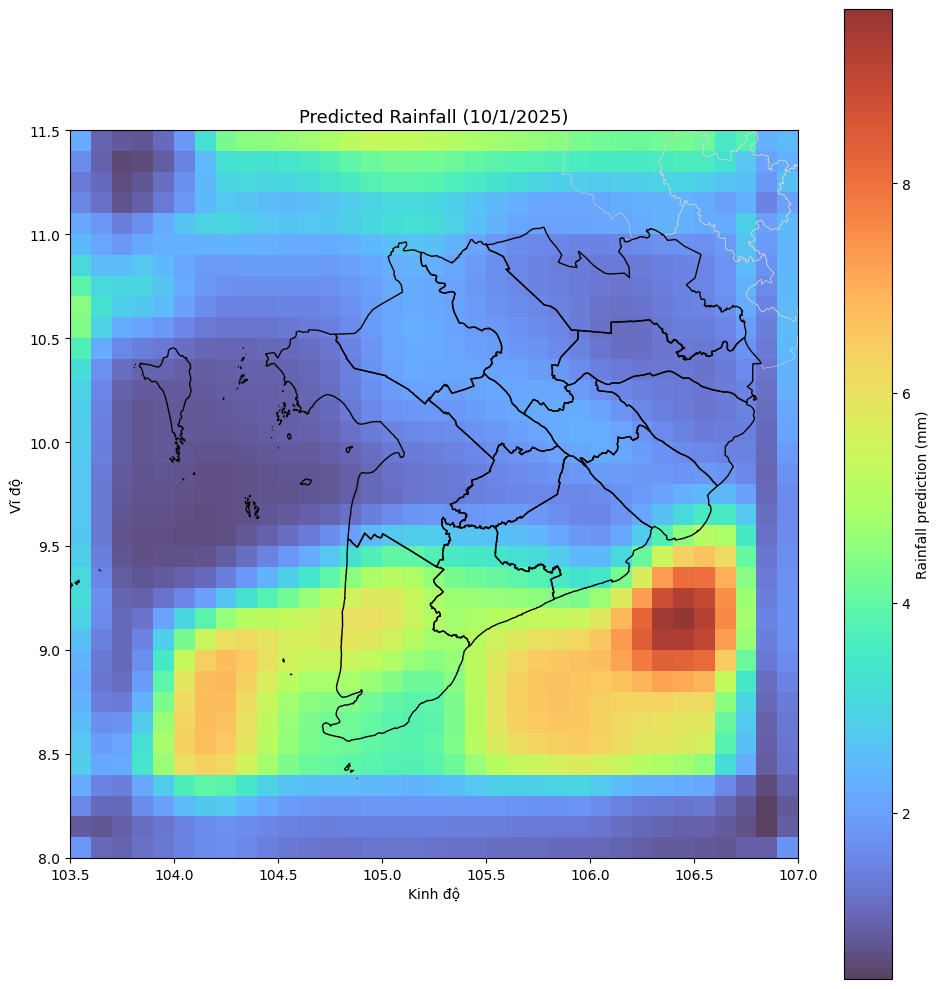

In [11]:
# ================================================================
# 📦 Rainfall Prediction Pipeline (ConvGRU + FPN)
# Author: Thanh Huy
# ================================================================
from datetime import datetime
import numpy as np
import torch
import matplotlib.pyplot as plt
import geopandas as gpd
import joblib


# ================================================================
# 🗺️ Visualization
# ================================================================
def plot_map(rain_map, title, vn_adm1, dbscl,
             min_lon=103.5, max_lon=107, min_lat=8, max_lat=11.5):
    """
    Hiển thị bản đồ dự đoán lượng mưa trên vùng ĐBSCL.
    rain_map: np.ndarray [H, W] – lượng mưa (mm/ngày)
    """
    extent = [min_lon, max_lon, min_lat, max_lat]
    fig, ax = plt.subplots(figsize=(10, 10))

    # Ranh giới hành chính
    vn_adm1.boundary.plot(ax=ax, color='lightgrey', linewidth=0.4)
    dbscl.boundary.plot(ax=ax, color='black', linewidth=1)

    # Overlay ma trận dự đoán
    im = ax.imshow(rain_map, extent=extent, origin='lower',
                   cmap='turbo', alpha=0.8)

    # Tùy chỉnh hiển thị
    plt.colorbar(im, ax=ax, label="Rainfall prediction (mm)")
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Kinh độ")
    ax.set_ylabel("Vĩ độ")
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    plt.tight_layout()
    plt.show()


# ================================================================
# 🔁 Forecasting Functions
# ================================================================
def autoregressive_forecast_last(model, initial_seq, n_days=7, device='cuda'):
    """
    Dự đoán autoregressive n_days bước tới bằng ConvGRU.

    Parameters
    ----------
    model : ConvGRUForecaster
        Mô hình Stage 1 đã train. Forward:
            input : [B, T_in, C_in, H, W]
            output: [B, 1, C_feat, H, W]
    initial_seq : torch.Tensor
        Lịch sử ban đầu, shape [1, time_in, C_in, H, W]
    n_days : int
        Số bước (ngày) cần dự đoán tiếp theo.

    Returns
    -------
    np.ndarray
        Feature của ngày cuối cùng sau n_days bước,
        shape [C_feat, H, W], vẫn đang ở không gian scaled.
    """
    model.eval()
    current_seq = initial_seq.to(device)
    preds = []

    with torch.no_grad():
        for _ in range(n_days):
            out = model(current_seq)              # [1, 1, C_feat, H, W]
            preds.append(out[0, 0].cpu().numpy()) # [C_feat, H, W]
            # Dịch cửa sổ thời gian: bỏ ngày đầu, thêm ngày mới
            current_seq = torch.cat([current_seq[:, 1:], out], dim=1)

    # Lấy feature của ngày cuối cùng
    return np.array(preds)[-1]  # [C_feat, H, W]


def inverse_scale_rainfall(pred_scaled, minmax, robust):
    """
    Inverse scaling cho rainfall từ không gian [0,1] (MinMax+Robust) về mm/ngày.

    Parameters
    ----------
    pred_scaled : np.ndarray hoặc torch.Tensor
        - shape [C, H, W] hoặc [H, W]
    minmax : sklearn MinMaxScaler
    robust : sklearn RobustScaler

    Returns
    -------
    np.ndarray
        Mảng [H, W] là rainfall (mm/ngày).
    """
    if isinstance(pred_scaled, torch.Tensor):
        pred_scaled = pred_scaled.detach().cpu().numpy()

    # Nếu còn channel dimension
    if pred_scaled.ndim == 3:  # [C, H, W]
        C, H, W = pred_scaled.shape
        flat = pred_scaled.reshape(-1, 1)
        inv = robust.inverse_transform(
            minmax.inverse_transform(flat)
        ).reshape(C, H, W)
        return inv[0]  # giả sử C=1 -> lấy channel 0
    elif pred_scaled.ndim == 2:  # [H, W]
        H, W = pred_scaled.shape
        flat = pred_scaled.reshape(-1, 1)
        inv = robust.inverse_transform(
            minmax.inverse_transform(flat)
        ).reshape(H, W)
        return inv
    else:
        raise ValueError(f"Unsupported pred_scaled shape: {pred_scaled.shape}")


# ================================================================
# 🚀 Main Pipeline (ConvGRU ➜ FPN)
# ================================================================
def main_predict(day, month, year):
    """
    Pipeline dự đoán lượng mưa cho một ngày cụ thể:
      1) Tính số ngày n_days từ 31/12/2024 đến (day,month,year)
      2) Dùng ConvGRUForecaster dự đoán feature đến đúng ngày đó
      3) Dùng RainfallFPN dự đoán rainfall từ feature của ngày đó
      4) Inverse scaling về mm/ngày
      5) Vẽ bản đồ ĐBSCL

    Yêu cầu:
      - train_dataset, test_dataset: FolderTimeSeriesDataset (Stage 1)
      - rain_train_dataset: TensorTimeSeriesDataset (Stage 2)
      - đã train và lưu:
          conv_gru_best.pth
          best_rainfall_fpn.pth
      - tồn tại:
          /content/data/minmax_scaler_target.pkl
          /content/data/robust_scaler_target.pkl
          /content/gadm41_VNM_1.json
    """
    # ----- Thông tin thời gian -----
    start_date = datetime(2024, 12, 31)
    end_date = datetime(year, month, day)
    n_days = (end_date - start_date).days
    print(f"⏳ Số ngày cần dự đoán từ 31/12/2024: {n_days} ngày")

    if n_days <= 0:
        raise ValueError("Ngày dự đoán phải sau 31/12/2024")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # ===== 1) Load ConvGRUForecaster (Stage 1) =====
    # train_dataset phải là FolderTimeSeriesDataset(...)
    X0, _ = train_dataset[0]          # X0: [time_in, C_in, H, W]
    input_channels = X0.shape[1]

    convgru_model = ConvGRUForecaster(
        input_channels=input_channels,
        hidden_dims=[64, 32, 16],
        kernel_size=3,
        dropout_rate=0.2
    ).to(device)

    ckpt_conv = torch.load('conv_gru_best.pth', map_location=device)
    convgru_model.load_state_dict(ckpt_conv['model_state_dict'])
    convgru_model.eval()

    # ===== 2) Load RainfallFPN (Stage 2) =====
    # rain_train_dataset phải là TensorTimeSeriesDataset(...)
    feat_sample, _ = rain_train_dataset[0]    # [C_feat, H, W]
    in_channels_fpn = feat_sample.shape[0]

    rain_model = RainfallFPN(
        in_channels=in_channels_fpn,
        base_channels=32,
        fpn_channels=64,
        dropout_rate=0.1
    ).to(device)

    ckpt_rain = torch.load('best_rainfall_fpn.pth', map_location=device)
    rain_model.load_state_dict(ckpt_rain['model_state_dict'])
    rain_model.eval()

    # (Optional) sanity check: số channel feature từ ConvGRU phải khớp FPN
    # ConvGRUForecaster output: C_feat = input_channels
    assert in_channels_fpn == input_channels, \
        f"Channel mismatch: ConvGRU out C={input_channels}, FPN in C={in_channels_fpn}"

    # ===== 3) Lấy chuỗi history cuối cùng (30 ngày feature) =====
    # test_dataset: FolderTimeSeriesDataset(...)
    pre_data, _ = test_dataset[-1]            # [time_in, C_in, H, W]
    pre_data = pre_data.unsqueeze(0).to(device)  # [1, time_in, C_in, H, W]

    # ===== 4) Autoregressive ConvGRU để ra feature ngày cần dự đoán =====
    feat_last_scaled = autoregressive_forecast_last(
        model=convgru_model,
        initial_seq=pre_data,
        n_days=n_days,
        device=device
    )  # [C_feat, H, W] (scaled feature)

    # ===== 5) Dự đoán rainfall từ feature ngày đó bằng FPN =====
    feat_last_tensor = torch.from_numpy(feat_last_scaled).unsqueeze(0).float().to(device)  # [1, C_feat, H, W]
    with torch.no_grad():
        rain_scaled = rain_model(feat_last_tensor)[0, 0].cpu().numpy()  # [H, W] (scaled)

    # ===== 6) Inverse scaling rainfall về mm/ngày =====
    minmax = joblib.load('/content/data/minmax_scaler_target.pkl')
    robust = joblib.load('/content/data/robust_scaler_target.pkl')

    pred_rain = inverse_scale_rainfall(rain_scaled, minmax, robust)  # [H, W] mm/ngày

    # ===== 7) Đọc shapefile & vẽ bản đồ =====
    vn_adm1 = gpd.read_file('/content/gadm41_VNM_1.json')
    mekong_provinces = [
        "LongAn", "TiềnGiang", "BếnTre", "TràVinh", "VĩnhLong",
        "ĐồngTháp", "AnGiang", "CầnThơ", "HậuGiang",
        "SócTrăng", "BạcLiêu", "CàMau", "KiênGiang"
    ]
    dbscl = vn_adm1[vn_adm1["NAME_1"].isin(mekong_provinces)]

    plot_map(
        pred_rain,
        title=f"Predicted Rainfall ({day}/{month}/{year})",
        vn_adm1=vn_adm1,
        dbscl=dbscl
    )


# ================================================================
# ▶️ Run Example
# ================================================================
if __name__ == "__main__":
    # Ví dụ: dự đoán lượng mưa ngày 05/01/2025
    main_predict(day=10, month=1, year=2025)
